# Statistics of annotated e-mails

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load the CSV files into DataFrames
email1_user1_df = pd.read_csv('EmailAnnotation1/user1.csv')
email1_pedro_df = pd.read_csv('EmailAnnotation1/pedro.csv')
email2_user3_df = pd.read_csv('EmailAnnotation2/user3.csv')
email2_artur_df = pd.read_csv('EmailAnnotation2/artur.csv')

In [3]:
# Merge the DataFrames based on the 'id' to compare annotations
email1_df = pd.merge(email1_user1_df, email1_pedro_df, on='id', suffixes=('_user1', '_pedro'))
email2_df = pd.merge(email2_user3_df, email2_artur_df, on='id', suffixes=('_user3', '_artur'))
email1_df.head(1)

# Ensure labels are strings
email1_df['label_user1'] = email1_df['label_user1'].astype(str)
email1_df['label_pedro'] = email1_df['label_pedro'].astype(str)
email2_df['label_user3'] = email2_df['label_user3'].astype(str)
email2_df['label_artur'] = email2_df['label_artur'].astype(str)

### Calcualte agreement and percentage

In [4]:
from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa for pairs of annotators
kappa_user1_pedro = cohen_kappa_score(email1_df['label_user1'], email1_df['label_pedro'])
kappa_user3_artur = cohen_kappa_score(email2_df['label_user3'], email2_df['label_artur'])

print("Cohen's Kappa between User1 and Pedro:", kappa_user1_pedro)
print("Cohen's Kappa between User3 and Artur:", kappa_user3_artur)

Cohen's Kappa between User1 and Pedro: 0.41396537258790334
Cohen's Kappa between User3 and Artur: 0.37104488249526413


In [4]:
# Function to calculate agreement and percentage
def calculate_agreement(df, label1, label2):
    agreement = df[label1] == df[label2]
    percentage_agreement = agreement.sum() / len(agreement)
    return agreement.sum(), percentage_agreement

# Calculate agreement and percentage for annotator pairs
agreement_user1_pedro, percentage_agreement_user1_pedro = calculate_agreement(email1_df, 'label_user1', 'label_pedro')
agreement_user3_artur, percentage_agreement_user3_artur = calculate_agreement(email2_df, 'label_user3', 'label_artur')

### Matrix of emotion pairs and their counts

In [5]:
# Function to build a matrix of emotion pairs and their counts
def build_emotion_pair_matrix(df, label1, label2):
    pairs = list(zip(df[label1], df[label2]))
    pair_counts = Counter(pairs)
    emotions = sorted(set(df[label1]) | set(df[label2]))
    matrix = pd.DataFrame(0, index=emotions, columns=emotions)
    
    for (emotion1, emotion2), count in pair_counts.items():
        matrix.loc[emotion1, emotion2] = count
    
    return matrix

# Build emotion pair matrices for annotator pairs
emotion_pair_matrix_user1_pedro = build_emotion_pair_matrix(email1_df, 'label_user1', 'label_pedro')
emotion_pair_matrix_user3_artur = build_emotion_pair_matrix(email2_df, 'label_user3', 'label_artur')

# Display the matrices as heatmaps
def plot_heatmap(matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.xlabel('pedro' if 'pedro' in title else 'artur')
    plt.ylabel('user1' if 'user1' in title else 'user3')
    plt.show()

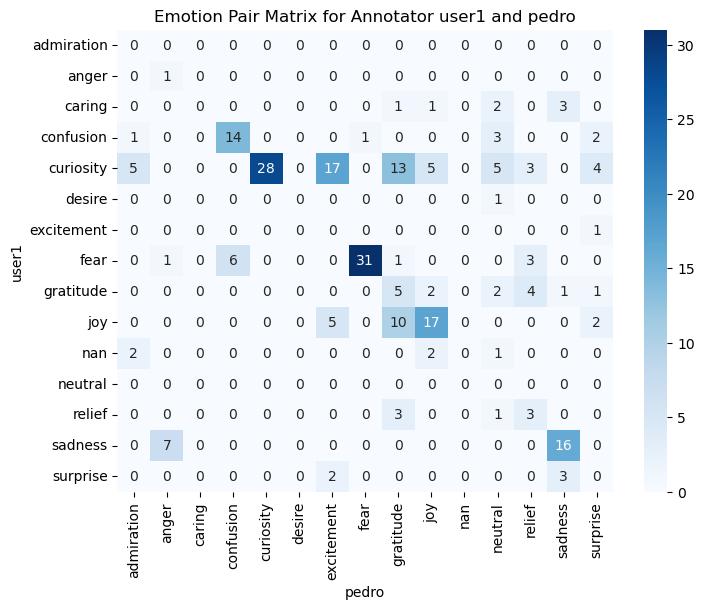

Agreement between Annotator user1 and pedro: 115 (47.52%)


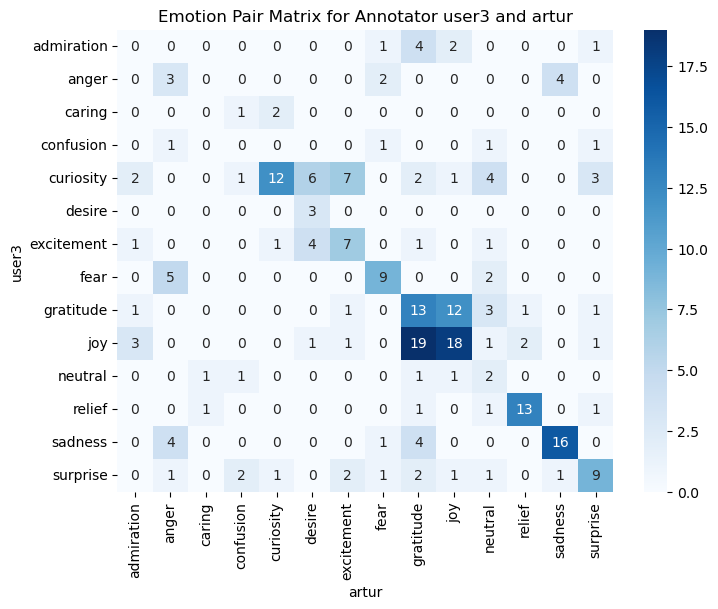

Agreement between Annotator user3 and artur: 105 (43.21%)


In [6]:
plot_heatmap(emotion_pair_matrix_user1_pedro, "Emotion Pair Matrix for Annotator user1 and pedro")
print(f'Agreement between Annotator user1 and pedro: {agreement_user1_pedro} ({percentage_agreement_user1_pedro:.2%})')
plot_heatmap(emotion_pair_matrix_user3_artur, "Emotion Pair Matrix for Annotator user3 and artur")
print(f'Agreement between Annotator user3 and artur: {agreement_user3_artur} ({percentage_agreement_user3_artur:.2%})')

## Generate csv files that will contain the disagreements from the annotation

In [40]:
# Analyze disagreements and export to CSV for manual decisions
def analyze_disagreements_export_csv(df, label1, label2, csv_filename):
    # Identify disagreements
    disagreements = df[df[label1] != df[label2]]

    # Prepare the data for export
    user1 = label1.split('_')[1]
    user2 = label2.split('_')[1]
    data_to_export = {
        'id': disagreements['id'],
        'text': disagreements['text_' + user1],  # Assuming text is the same for both users
        f'{user1}_emotion': disagreements[label1],
        f'{user2}_emotion': disagreements[label2],
        'chosen_emotion': [None] * len(disagreements),  # Empty column for manual input
        'correct_emotion': [None] * len(disagreements)  # Empty column for manual input (more correct/ only correct)
    }

    # Convert dictionary to DataFrame
    decisions_df = pd.DataFrame(data_to_export)

    # Export to CSV
    decisions_df.to_csv(csv_filename, index=False)
    print(f"Data exported to {csv_filename} with {len(disagreements)} entries.")

# Analyze disagreements for annotator pairs and export to csv
analyze_disagreements_export_csv(email1_df, 'label_user1', 'label_pedro', 'email1_user1_pedro.csv')
analyze_disagreements_export_csv(email2_df, 'label_user3', 'label_artur', 'email2_user3_artur.csv')

Data exported to email1_user1_pedro.csv with 127 entries.
Data exported to email2_user3_artur.csv with 138 entries.


## Analyzing the chosen emotions of disagreements

In [7]:
# Load the CSV files into DataFrames
email1_user1_pedro_df = pd.read_csv('email1_disagreements_selected_emotion.csv')
email2_user3_artur_df = pd.read_csv('email2_disagreements_selected_emotion.csv')

In [8]:
# Count the occurrences of each value in the 'chosen_emotion' column
email1_emotion_counts = email1_user1_pedro_df['chosen_emotion'].value_counts()
email1_correct_counts = email1_user1_pedro_df['correct_emotion'].value_counts()
email2_emotion_counts = email2_user3_artur_df['chosen_emotion'].value_counts()
email2_correct_counts = email2_user3_artur_df['correct_emotion'].value_counts()

# Get the counts for each specific category
# Email 1
count_cant = email1_emotion_counts.get('cant', 0)
count_only_correct = email1_correct_counts.get('only correct', 0)
count_more_correct = email1_correct_counts.get('more correct', 0)
count_decided = count_only_correct + count_more_correct
# Email 2
count_cant2 = email2_emotion_counts.get('cant', 0)
count_only_correct2 = email2_correct_counts.get('only correct', 0)
count_more_correct2 = email2_correct_counts.get('more correct', 0)
count_decided2 = count_only_correct2 + count_more_correct2

# Display the results
print("EMAIL 1 - user1 and pedro")
print(f"Total entries to decide: {len(email1_user1_pedro_df)}")
print(f"Decided (Only correct + More correct): {count_decided}")
print(f"Only correct: {count_only_correct}")
print(f"More correct: {count_more_correct}")
print(f"Can't decide: {count_cant}")
print()
print("EMAIL 2 - user3 and artur")
print(f"Total entries to decide: {len(email2_user3_artur_df)}")
print(f"Decided (Only correct + More correct): {count_decided2}")
print(f"Only correct: {count_only_correct2}")
print(f"More correct: {count_more_correct2}")
print(f"Can't decide: {count_cant2}")

EMAIL 1 - user1 and pedro
Total entries to decide: 127
Decided (Only correct + More correct): 124
Only correct: 19
More correct: 105
Can't decide: 3

EMAIL 2 - user3 and artur
Total entries to decide: 138
Decided (Only correct + More correct): 127
Only correct: 13
More correct: 114
Can't decide: 11


### Email 1, check the can't decide entries

In [9]:
# Email1
# Filter the rows where 'chosen_emotion' is 'cant'
cant_df = email1_user1_pedro_df[email1_user1_pedro_df['chosen_emotion'] == 'cant']

# Select relevant columns: 'text', 'user1_emotion', 'pedro_emotion'
cant_detailed_df = cant_df[['text', 'user1_emotion', 'pedro_emotion']]

# Ensure the entire text is displayed
pd.set_option('display.max_colwidth', None)

# Display the rows where it was difficult to make a choice
print("EMAIL 1")
print("Detailed analysis of 'cant' entries:")
print(cant_detailed_df)

EMAIL 1
Detailed analysis of 'cant' entries:
                                                                                                                                                                                                      text  \
32                                                                              The directions provided were quite vague, and I'm unsure how to proceed. Could you provide more clarity? Best, [Your Name]   
33                                                                                 The latest updates have left me puzzled. Could you explain the reasoning behind these decisions? Thank you, [Your Name]   
76  Your safety is our top concern, and as part of our ongoing efforts to protect your information, we recommend updating your password from time to time. Click here to make these important changes now.   

   user1_emotion pedro_emotion  
32     confusion       neutral  
33     confusion    admiration  
76        relief       neutral 

### Email 2, check the can't decide entries

In [10]:
# Email2
# Filter the rows where 'chosen_emotion' is 'cant'
cant_df2 = email2_user3_artur_df[email2_user3_artur_df['chosen_emotion'] == 'cant']

# Select relevant columns: 'text', 'user1_emotion', 'pedro_emotion'
cant_detailed_df2 = cant_df2[['text', 'user3_emotion', 'artur_emotion']]

# Ensure the entire text is displayed
pd.set_option('display.max_colwidth', None)

# Display the rows where it was difficult to make a choice
print("EMAIL 2")
print("Detailed analysis of 'cant' entries:")
print(cant_detailed_df2)

EMAIL 2
Detailed analysis of 'cant' entries:
                                                                                                                                                                                                                                                                                                                                                                                         text  \
1                                                                                                 A security incident has been detected on our platform involving a potential breach of user accounts. To safeguard against further threats, please change your password immediately by clicking here: [secure link]. Delaying action could result in irreparable harm to your personal data.   
16                                                                                  We are thrilled to announce that we have saved the best for last - an exclusive offer tailored just f

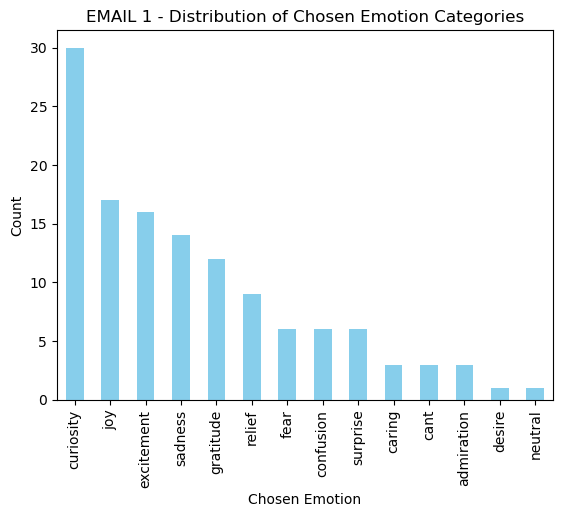

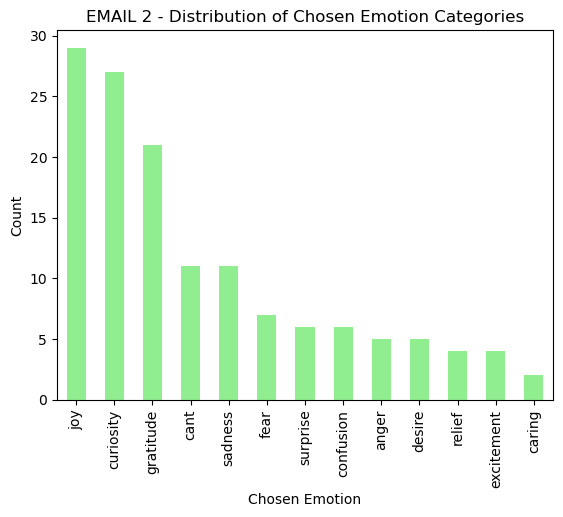

In [11]:
# Visualization 1: Bar plot of the distribution of 'chosen_emotion' categories
counts = email1_user1_pedro_df['chosen_emotion'].value_counts()
counts.plot(kind='bar', color='skyblue')
plt.title('EMAIL 1 - Distribution of Chosen Emotion Categories')
plt.xlabel('Chosen Emotion')
plt.ylabel('Count')
plt.show()

counts2 = email2_user3_artur_df['chosen_emotion'].value_counts()
counts2.plot(kind='bar', color='lightgreen')
plt.title('EMAIL 2 - Distribution of Chosen Emotion Categories')
plt.xlabel('Chosen Emotion')
plt.ylabel('Count')
plt.show()


## Export the final annotated data to csv

In [12]:
# 1. Identify agreement entries and select required columns
email1_agree_df = email1_df[email1_df['label_user1'] == email1_df['label_pedro']]
email1_agree_df = email1_agree_df[['id', 'text_user1', 'label_user1']].rename(columns={'label_user1': 'emotion', 'text_user1': 'text'})

email2_agree_df = email2_df[email2_df['label_user3'] == email2_df['label_artur']]
email2_agree_df = email2_agree_df[['id', 'text_user3', 'label_user3']].rename(columns={'label_user3': 'emotion', 'text_user3': 'text'})

# 2. Filter out "cant" entries and select required columns from disagreement DataFrames
email1_disagreement_df = email1_user1_pedro_df[email1_user1_pedro_df['chosen_emotion'] != 'cant']
email1_disagreement_df = email1_disagreement_df[['id', 'text', 'chosen_emotion']].rename(columns={'chosen_emotion': 'emotion'})

email2_disagreement_df = email2_user3_artur_df[email2_user3_artur_df['chosen_emotion'] != 'cant']
email2_disagreement_df = email2_disagreement_df[['id', 'text', 'chosen_emotion']].rename(columns={'chosen_emotion': 'emotion'})

# 3. Combine the agreement entries with the resolved disagreements
email1_final_df = pd.concat([email1_agree_df, email1_disagreement_df], ignore_index=True)
email2_final_df = pd.concat([email2_agree_df, email2_disagreement_df], ignore_index=True)

# 4. Combine the final DataFrames for email1 and email2
final_df = pd.concat([email1_final_df, email2_final_df], ignore_index=True)

# 5. Save the final DataFrame to a CSV file with only 'id', 'text', and 'emotion' columns
final_df.to_csv('final_annotations.csv', index=False)

# Get the amount of annotated data
print(f"Total annotated data: {len(final_df)}")

Total annotated data: 471


## Stratificate the data into 80% and 20% subsets

In [77]:
# Perform stratified split
stratified_sample_20, stratified_sample_80 = train_test_split(
    final_df, 
    test_size=0.8,   # 80% of data goes into the larger subset
    stratify=final_df['emotion'],  # Stratify by the 'emotion' label
    random_state=42  # Ensure reproducibility
)

In [73]:
# Check the distribution in the original and split datasets
print("Original dataset distribution:\n", final_df['emotion'].value_counts(normalize=True))
print('\n20%-sample distribution:\n', stratified_sample_20['emotion'].value_counts(normalize=True))
print("\n80%-sample distribution:\n", stratified_sample_80['emotion'].value_counts(normalize=True))

Original dataset distribution:
 emotion
curiosity     0.205945
joy           0.171975
sadness       0.121019
fear          0.112527
gratitude     0.108280
relief        0.061571
excitement    0.057325
confusion     0.055202
surprise      0.044586
anger         0.019108
desire        0.019108
caring        0.010616
neutral       0.006369
admiration    0.006369
Name: proportion, dtype: float64

20%-sample distribution:
 emotion
curiosity     0.202128
joy           0.170213
fear          0.117021
sadness       0.117021
gratitude     0.106383
relief        0.063830
excitement    0.053191
confusion     0.053191
surprise      0.042553
anger         0.021277
desire        0.021277
neutral       0.010638
caring        0.010638
admiration    0.010638
Name: proportion, dtype: float64

80%-sample distribution:
 emotion
curiosity     0.206897
joy           0.172414
sadness       0.122016
fear          0.111406
gratitude     0.108753
relief        0.061008
excitement    0.058355
confusion     0.055

In [74]:
# Save the stratified samples to CSV files
stratified_sample_20.to_csv('stratified_sample_20.csv', index=False)
stratified_sample_80.to_csv('stratified_sample_80.csv', index=False)